In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
# Zonals stats packages
import rasterstats as rs
import earthpy as et

os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

## Import Canopy Height Model
 

In [32]:
sjer_chm_path = "data/spatial-vector-lidar/california/neon-sjer-site/2013/lidar/SJER_lidarCHM.tif"

with rio.open(sjer_chm_path) as sjer_lidar_chm_src:
    sjer_chm_data = sjer_lidar_chm_src.read(1, masked=True)
    # Create metadata object to view later
    sjer_chm_data_meta = sjer_lidar_chm_src.profile
    sjer_plot_extent = plotting_extent(sjer_lidar_chm_src)

sjer_chm_data.shape
# view metadata 
sjer_chm_data_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 4296, 'height': 5059, 'count': 1, 'crs': CRS({'init': 'epsg:32611'}), 'transform': Affine(1.0, 0.0, 254571.0,
       0.0, -1.0, 4112362.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

## Plot a histogram

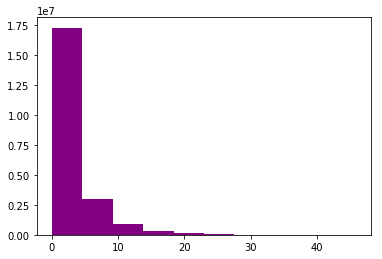

In [18]:
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(sjer_chm_data.ravel(), color="purple")
plt.show()

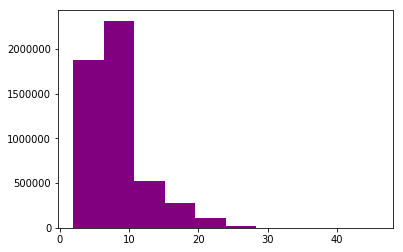

In [23]:
# Set all values ==0 to na (no data) 
# as 0s will bring down our summary mean values
sjer_chm_data[sjer_chm_data == 0] = np.nan
# Remove na values from the array
# Only perform this step for the histogram! 
# Not needed for your data processing
sjer_chm_data_no_na = sjer_chm_data[~np.isnan(sjer_chm_data)]

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(sjer_chm_data_no_na.ravel(), color="purple")
plt.show()

## Import The Plot Location Data

In [29]:
sjer_centroids_path = "data/spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_plot_centroids.shp"
sjer_plot_points = gpd.read_file(sjer_centroids_path)
sjer_plot_points.head(3)

,Plot_ID,Point,northing,easting,plot_type,geometry
0,SJER1068,center,4111567.818,255852.376,trees,POINT (255852.376 4111567.818)
1,SJER112,center,4111298.971,257406.967,trees,POINT (257406.967 4111298.971)
2,SJER116,center,4110819.876,256838.760,grass,POINT (256838.76 4110819.876)


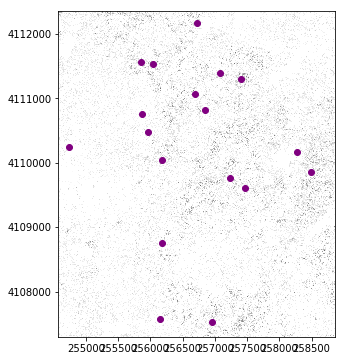

In [34]:
# overlay the points on top of the raster chm file 
fig, ax = plt.subplots(figsize=(6,6))
# Plot a RASTER layer which is an IMAGE using imshow
ax.imshow(sjer_chm_data,
         cmap="Greys",
         extent=sjer_plot_extent)
# Plot a geopandas VECTOR layer which is a (shapefile in this case)
sjer_plot_points.plot(ax=ax,
                     color="purple")
plt.show()

# Buffer the points to make a polygon 

In [37]:
# Buffer the points
sjer_plots_poly = sjer_plot_points.copy()
sjer_plots_poly["geometry"] = sjer_plot_points.geometry.buffer(20)
sjer_plots_poly

# Export data as a shapefile
plot_buffer_path = "data/spatial-vector-lidar/outputs/sjer_plot_buffer.shp"
sjer_plots_poly.to_file(plot_buffer_path)


In [54]:
# Run zonal stats 
sjer_lidar_tree_heights = rs.zonal_stats(plot_buffer_path,
                                        sjer_chm_data,
                                        affine=sjer_chm_data_meta["transform"],
                                        geojson_out=True,
                                        copy_properties=True,
                                        nodata=0, 
                                        stats=["mean", "max"])
type(sjer_lidar_tree_heights)
# conver the list output to a geodataframe

sjer_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_lidar_tree_heights)
sjer_lidar_height_df.head()

,Plot_ID,Point,easting,geometry,max,mean,northing,plot_type
0,SJER1068,center,255852.376,"POLYGON ((255872.376 4111567.818, 255872.27969...",19.049999,11.544348,4111567.818,trees
1,SJER112,center,257406.967,"POLYGON ((257426.967 4111298.971, 257426.87069...",24.019999,10.369277,4111298.971,trees
2,SJER116,center,256838.760,"POLYGON ((256858.76 4110819.876, 256858.663694...",16.070000,7.518398,4110819.876,grass
3,SJER117,center,256176.947,"POLYGON ((256196.947 4108752.026, 256196.85069...",11.059999,7.675347,4108752.026,trees
4,SJER120,center,255968.372,"POLYGON ((255988.372 4110476.079, 255988.27569...",5.740000,4.591176,4110476.079,grass


## Compare Human Measured Tree Heights

In [61]:
# Import the csv of human measured (insitu) tree height data
path_insitu = "data/spatial-vector-lidar/california/neon-sjer-site/2013/insitu/veg_structure/D17_2013_SJER_vegStr.csv"
sjer_insitu_all = pd.read_csv(path_insitu)
sjer_insitu_all.columns

# Keep only the needed columns
sjer_insitu = sjer_insitu_all[["siteid","sitename","plotid","stemheight"]]
sjer_insitu.head()

,siteid,sitename,plotid,stemheight
0,SJER,San Joaquin,SJER128,18.2
1,SJER,San Joaquin,SJER2796,3.3
2,SJER,San Joaquin,SJER272,1.7
3,SJER,San Joaquin,SJER112,2.1
4,SJER,San Joaquin,SJER272,3.0


In [73]:
# Get mean and max tree height for each plot
insitu_stem_ht = sjer_insitu.groupby("plotid").agg(["mean","max"])["stemheight"]
insitu_stem_ht = insitu_stem_ht.reset_index()
insitu_stem_ht.head()

,plotid,mean,max
0,SJER1068,3.866667,19.3
1,SJER112,8.221429,23.9
2,SJER116,8.218750,16.0
3,SJER117,6.512500,11.0
4,SJER120,7.600000,8.8


In [76]:
# Merge the lidar df with the insitu by the plot id

sjer_final_height = sjer_lidar_height_df.merge(insitu_stem_ht,
                          left_on="Plot_ID",
                          right_on="plotid")